In [1]:
# import time
# import serial
# # arduino = serial.Serial(port='COM5', baudrate=9600, timeout=.1)
# time.sleep(2)

In [2]:
import os
import cv2
import time
import mediapipe as mp
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import itertools
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm

In [3]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

In [4]:
keypoints = [
    mp_hands.HandLandmark.WRIST,
    mp_hands.HandLandmark.THUMB_CMC,
    mp_hands.HandLandmark.THUMB_MCP,
    mp_hands.HandLandmark.THUMB_IP,
    mp_hands.HandLandmark.THUMB_TIP,
    mp_hands.HandLandmark.INDEX_FINGER_MCP,
    mp_hands.HandLandmark.INDEX_FINGER_PIP,
    mp_hands.HandLandmark.INDEX_FINGER_DIP,
    mp_hands.HandLandmark.INDEX_FINGER_TIP,
    mp_hands.HandLandmark.MIDDLE_FINGER_MCP,
    mp_hands.HandLandmark.MIDDLE_FINGER_PIP,
    mp_hands.HandLandmark.MIDDLE_FINGER_DIP,
    mp_hands.HandLandmark.MIDDLE_FINGER_TIP,
    mp_hands.HandLandmark.RING_FINGER_MCP,
    mp_hands.HandLandmark.RING_FINGER_PIP,
    mp_hands.HandLandmark.RING_FINGER_DIP,
    mp_hands.HandLandmark.RING_FINGER_TIP,
    mp_hands.HandLandmark.PINKY_MCP,
    mp_hands.HandLandmark.PINKY_PIP,
    mp_hands.HandLandmark.PINKY_DIP,
    mp_hands.HandLandmark.PINKY_TIP,
]

In [5]:
if not os.path.exists("Dataset.csv"):
    with mp_hands.Hands(
        static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5
    ) as hands:
        list_name = [
            "Wrist_x",
            "Wrist_y",
            "Thumb_cmc_x",
            "Thumb_cmc_y",
            "Thumb_mcp_x",
            "Thumb_mcp_y",
            "Thumb_ip_x",
            "Thumb_ip_y",
            "Thumb_tip_x",
            "Thumb_tip_y",
            "Index_finger_mcp_x",
            "Index_finger_mcp_y",
            "Index_finger_pip_x",
            "Index_finger_pip_y",
            "Index_finger_dip_x",
            "Index_finger_dip_y",
            "Index_finger_tip_x",
            "Index_finger_tip_y",
            "Middle_finger_mcp_x",
            "Middle_finger_mcp_y",
            "Middle_finger_pip_x",
            "Middle_finger_pip_y",
            "Middle_finger_dip_x",
            "Middle_finger_dip_y",
            "Middle_finger_tip_x",
            "Middle_finger_tip_y",
            "Ring_finger_mcp_x",
            "Ring_finger_mcp_y",
            "Ring_finger_pip_x",
            "Ring_finger_pip_y",
            "Ring_finger_dip_x",
            "Ring_finger_dip_y",
            "Ring_finger_tip_x",
            "Ring_finger_tip_y",
            "Pinky_mcp_x",
            "Pinky_mcp_y",
            "Pinky_pip_x",
            "Pinky_pip_y",
            "Pinky_dip_x",
            "Pinky_dip_y",
            "Pinky_tip_x",
            "Pinky_tip_y",
        ]
        header = ["filename", "class_name", "class_no"]
        for i in range(len(list_name)):
            header.append(list_name[i])
        with open("Dataset.csv", "w") as f:
            f.write(",".join(header) + "\n")
        for class_ in os.listdir("Dataset"):
            for image in tqdm(
                os.listdir("Dataset/" + class_),
                desc="Processing",
                unit="image",
                total=len(os.listdir("Dataset/" + class_)),
            ):
                image_path = "Dataset/" + class_ + "/" + image
                image = cv2.flip(cv2.imread(image_path), 1)
                results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                if not results.multi_hand_landmarks:
                    continue
                for hand_landmarks in results.multi_hand_landmarks:
                    row = [image_path, class_, os.listdir("Dataset").index(class_)]
                    for i in range(len(keypoints)):
                        row.append(hand_landmarks.landmark[keypoints[i]].x)
                        row.append(hand_landmarks.landmark[keypoints[i]].y)
                    with open("Dataset.csv", "a") as f:
                        f.write(",".join([str(i) for i in row]) + "\n")

In [6]:
csvs_out_train_path = "Dataset.csv"

In [7]:
def get_coords(csv_path):

    df = pd.read_csv(csv_path)
    df1 = df.copy()
    df1.drop(columns=["filename"], inplace=True)
    classes = df1.pop("class_name").unique()
    y = df1.pop("class_no")
    x = df1.astype("float64")
    y = keras.utils.to_categorical(y)

    return x, y, classes, df

In [8]:
x, y, classes, df = get_coords(csvs_out_train_path)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.15)

In [9]:
def embed_coords(scores):

    reshaped_inputs = keras.layers.Reshape((21, 2))(scores)
    points = reshaped_inputs
    embedding = keras.layers.Flatten()(points)

    return embedding

In [10]:
inputs = tf.keras.Input(shape=(42))
embedding = embed_coords(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(classes), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 42)]              0         
                                                                 
 reshape (Reshape)           (None, 21, 2)             0         
                                                                 
 flatten (Flatten)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 128)               5504      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0    


Epoch 1/200


2047/2069 [============================>.] - ETA: 0s - loss: 0.6125 - accuracy: 0.7492
Epoch 1: val_accuracy improved from -inf to 0.89264, saving model to weights.best.hdf5
2069/2069 [==============================] - 7s 3ms/step - loss: 0.6093 - accuracy: 0.7504 - val_loss: 0.1954 - val_accuracy: 0.8926
Epoch 2/200
  47/2069 [..............................] - ETA: 4s - loss: 0.2670 - accuracy: 0.8723

C:\Users\shrey\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2064/2069 [============================>.] - ETA: 0s - loss: 0.2267 - accuracy: 0.8989
Epoch 2: val_accuracy improved from 0.89264 to 0.97106, saving model to weights.best.hdf5
2069/2069 [==============================] - 5s 3ms/step - loss: 0.2267 - accuracy: 0.8989 - val_loss: 0.1140 - val_accuracy: 0.9711
Epoch 3/200
2059/2069 [============================>.] - ETA: 0s - loss: 0.1516 - accuracy: 0.9437
Epoch 3: val_accuracy improved from 0.97106 to 0.98048, saving model to weights.best.hdf5
2069/2069 [==============================] - 5s 3ms/step - loss: 0.1515 - accuracy: 0.9437 - val_loss: 0.0655 - val_accuracy: 0.9805
Epoch 4/200
2062/2069 [============================>.] - ETA: 0s - loss: 0.1028 - accuracy: 0.9648
Epoch 4: val_accuracy improved from 0.98048 to 0.99366, saving model to weights.best.hdf5
2069/2069 [==============================] - 5s 3ms/step - loss: 0.1026 - accuracy: 0.9648 - val_loss: 0.0280 - val_accuracy: 0.9937
Epoch 5/200
2055/2069 [=======================

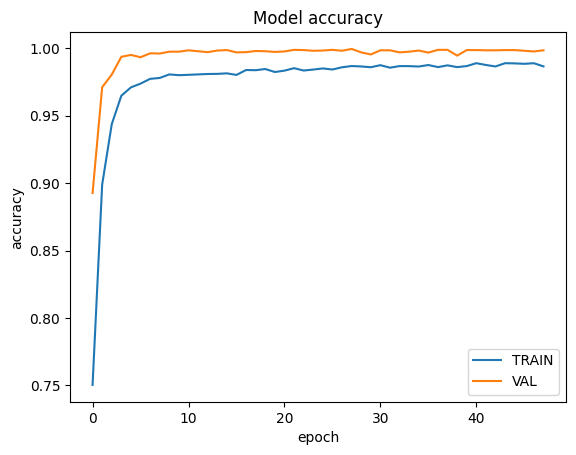

In [11]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max"
)
earlystopping = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=20)


history = model.fit(
    x_train,
    y_train,
    epochs=200,
    batch_size=16,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint, earlystopping],
)

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["TRAIN", "VAL"], loc="lower right")
plt.show()


183/183 [==============================] - 0s 1ms/step
(5840, 42) (5840, 6) <class 'numpy.ndarray'> <class 'pandas.core.frame.DataFrame'>
Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

      Class0       0.99      1.00      0.99       845
      Class1       1.00      0.99      1.00       983
      Class2       1.00      1.00      1.00      1067
      Class3       1.00      1.00      1.00      1428
      Class4       1.00      1.00      1.00       734
      Class5       1.00      1.00      1.00       783

    accuracy                           1.00      5840
   macro avg       1.00      1.00      1.00      5840
weighted avg       1.00      1.00      1.00      5840



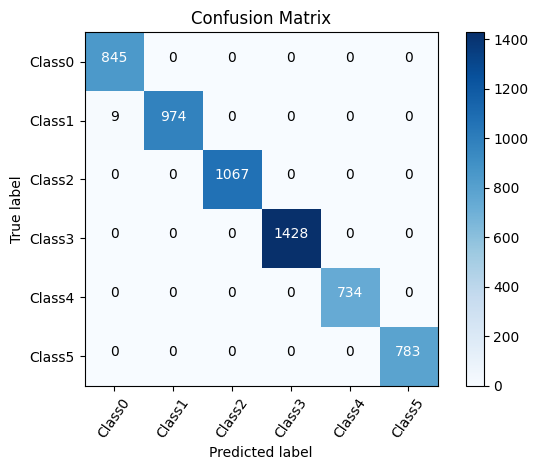

In [12]:
def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues
):

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()


y_pred = model.predict(x_val)
print(x_val.shape, y_pred.shape, type(y_pred), type(x_val))

y_pred_label = [classes[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [classes[i] for i in np.argmax(y_val, axis=1)]

cm = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm, classes, title="Confusion Matrix")

print("\nClassification Report:\n", classification_report(y_true_label, y_pred_label))

In [19]:
model.save("model.h5")

C:\Users\shrey\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
loaded_model = keras.models.load_model("model.h5")

In [13]:
x_val.shape

(5840, 42)

In [22]:
def detectSign(image):
    with mp_hands.Hands(
        static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5
    ) as hands:
        results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if not results.multi_hand_landmarks:
            return None, None
        coordinates = np.array(
            [[res.x, res.y] for res in results.multi_hand_landmarks[0].landmark]
        ).flatten()
        X = coordinates.reshape(1, 42)
        y = loaded_model.predict(X)
        y_pred = [classes[i] for i in np.argmax(y, axis=1)]
        return y_pred[0], np.argmax(y, axis=1)[0]

In [23]:
# findSpeed(cv2.imread("Dataset\\Class4\\image37.jpg"))

In [24]:
camera_video = cv2.VideoCapture(0)
camera_video.set(3, 1280)
camera_video.set(4, 720)
cv2.namedWindow("Hand Gesture Recognition", cv2.WINDOW_NORMAL)

while camera_video.isOpened():
    ok, frame = camera_video.read()
    time1 = time.time()
    if not ok:
        continue

    frame_height, frame_width, _ = frame.shape

    fingers, num = detectSign(frame)
    print(fingers)
    frame = cv2.flip(frame, 1)
    time2 = time.time()
    fps = 0
    if (time2 - time1) > 0:
        fps = 1.0 / (time2 - time1)
    cv2.putText(
        frame,
        "FPS: {}".format(int(fps)),
        (500, 150),
        cv2.FONT_HERSHEY_PLAIN,
        3,
        (0, 255, 0),
        3,
    )
    cv2.putText(
        frame,
        "CLASS: {}".format(fingers),
        (10, 150),
        cv2.FONT_HERSHEY_PLAIN,
        3,
        (0, 255, 0),
        3,
    )
    time1 = time2

    cv2.imshow("Hand Gesture Recognition", frame)
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break
camera_video.release()
cv2.destroyAllWindows()

None
None
None
None
None
None
None
None
None
None
None
None
None
None
1/1 [==============================] - 0s 25ms/step
Class5
1/1 [==============================] - 0s 24ms/step
Class5
1/1 [==============================] - 0s 24ms/step
Class5
1/1 [==============================] - 0s 22ms/step
Class5
1/1 [==============================] - 0s 25ms/step
Class5
1/1 [==============================] - 0s 25ms/step
Class5
1/1 [==============================] - 0s 29ms/step
Class5
1/1 [==============================] - 0s 42ms/step
Class5
1/1 [==============================] - 0s 25ms/step
Class5
None
None
1/1 [==============================] - 0s 24ms/step
Class4
1/1 [==============================] - 0s 24ms/step
Class4
1/1 [==============================] - 0s 24ms/step
Class4
1/1 [==============================] - 0s 23ms/step
Class4
1/1 [==============================] - 0s 24ms/step
Class3
1/1 [==============================] - 0s 25ms/step
Class4
1/1 [==============================